In [1]:
import argparse
import os
import shutil
import sys
import pickle
import h5py
import torch
import numpy as np
import json
import lib.init as init
from lib.runner import runner
import matplotlib.pyplot as plt

In [ ]:
# save stdout and stderr location
stdout = sys.stdout
stderr = sys.stderr

config_file = 'configs/re15k.json'
with open(config_file, "r") as f:
    config = json.load(f)
        
config['overwrite'] = None
config['mode'] = 'eval'
device = ('cuda' if torch.cuda.is_available() else "cpu")
config['device'] = device
run = runner(config)

# reopen stdout and stderr
sys.stdout = stdout
sys.stderr = stderr

In [3]:
run.eval()

####################	Predicting...       	####################
Time taken for long-term prediction:  15.122267246246338
Time taken per prediction:  0.0025203778743743896
Predictions shape: (6000, 1, 38988)
Saving predictions to file


In [4]:
time_lag = run.config['params']['time_lag']

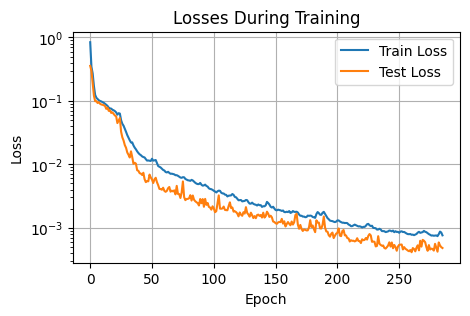

In [5]:
# load losses.pkl
with open(run.paths_bib.model_dir + 'losses.pkl', 'rb') as f:
    loss = pickle.load(f)
train_loss = loss['train_losses']
test_loss = loss['test_losses']

plt.figure(figsize=(5,3))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.title('Losses During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [6]:
val_indices = run.val_indices
train_indices = run.train_indices

In [8]:
print(run.paths_bib.predictions_dir + 'val_pred.h5')

results/ldc_15k/dls_p19m5/tr_enc_t64_ta1_l4_d512_h4_train0_7_test0_1_Ntrain0_Ntest0/pred/val_pred.h5


In [9]:
# load predictions
with h5py.File(run.paths_bib.predictions_dir + 'val_pred.h5', 'r') as f:
    pred_u = f['dof_u'][:]
    pred_v = f['dof_v'][:]

predictions = np.concatenate((pred_u, pred_v), axis=1)

In [10]:
val_indices = np.array(val_indices)[:len(predictions)]

In [11]:
with h5py.File(run.paths_bib.latent_path, 'r') as f:
    dof = np.zeros((len(predictions),2* f['dof_u'].shape[1]), dtype=np.float32)
    for i, idx in enumerate(val_indices):
        # print(idx)
        dof_u = f['dof_u'][idx:idx+1]
        dof_v = f['dof_v'][idx:idx+1]
        dof[i] = np.concatenate((dof_u, dof_v), axis=1)

In [13]:
l2_err_time = np.linalg.norm(predictions - dof, axis=1) / np.linalg.norm(dof, axis=1)
print('L2 error:', 100*l2_err_time.mean(), '%')

L2 error: 5.752074718475342 %


In [14]:
time_range = np.arange(val_indices[0],val_indices[0] + len(predictions), 1) /100

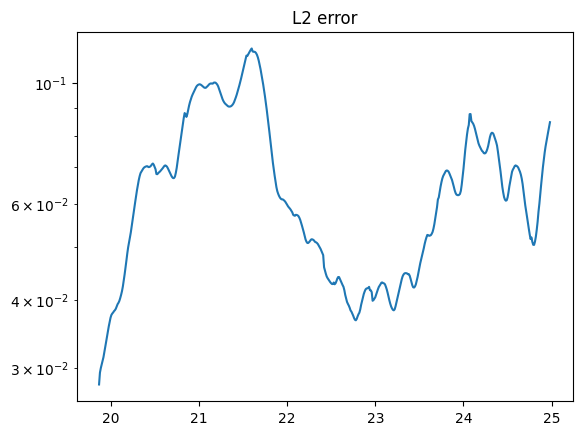

In [15]:
plt.plot(time_range[time_lag:], l2_err_time[time_lag:], label='L2 error')
plt.yscale('log')
plt.title('L2 error')
plt.show()

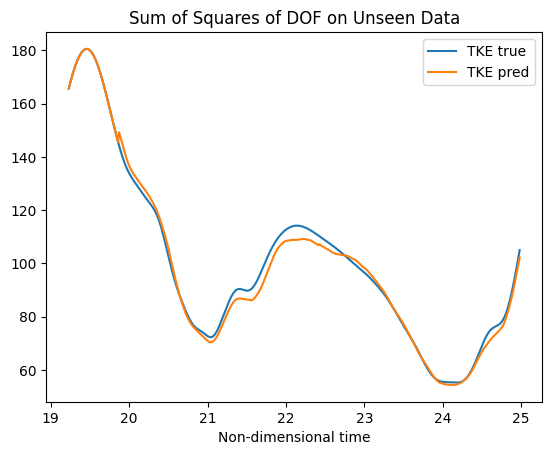

In [16]:
tke_true = 1/2 * np.sum(dof**2, axis=1)
tke_pred = 1/2 * np.sum(predictions**2, axis=1)
# plot tkes
plt.figure()
plt.plot(time_range, tke_true, label='TKE true')
plt.plot(time_range, tke_pred, label='TKE pred')
plt.legend()
plt.title('Sum of Squares of DOF on Unseen Data')
plt.xlabel('Non-dimensional time')
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.show()


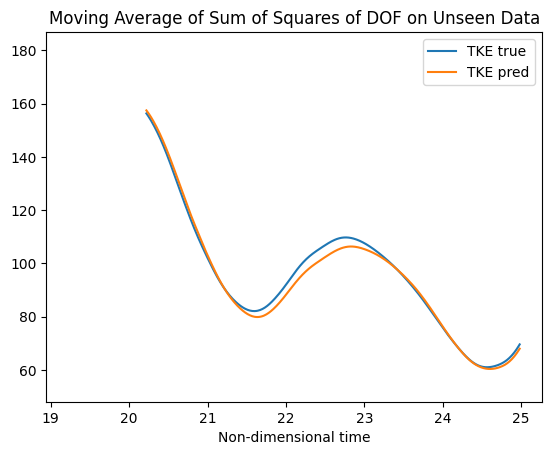

In [17]:
# plot moving average of TKE
def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size
window_size = 100
tke_true_ma = moving_average(tke_true, window_size)
tke_pred_ma = moving_average(tke_pred, window_size) 
t_ma = time_range[window_size-1:]
plt.figure()
plt.plot(t_ma, tke_true_ma, label='TKE true')
plt.plot(t_ma, tke_pred_ma, label='TKE pred')
plt.legend()
plt.title('Moving Average of Sum of Squares of DOF on Unseen Data')
plt.xlabel('Non-dimensional time')
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.show()

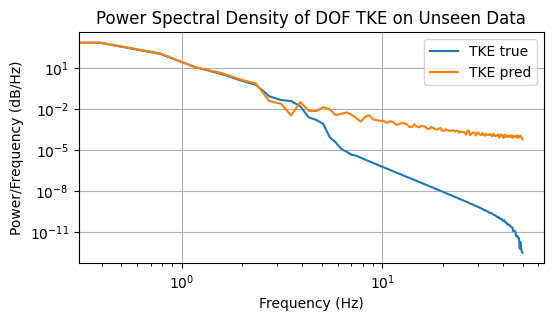

In [18]:
# plot psds of TKE together using welch method
from scipy.signal import welch
def plot_psd(data, fs, label):
    f, Pxx = welch(data, fs=fs)
    plt.loglog(f, Pxx, label=label)
fs = 100
plt.figure(figsize=(6,3))
plot_psd(tke_true, fs, 'TKE true')
plot_psd(tke_pred, fs, 'TKE pred')
plt.title('Power Spectral Density of DOF TKE on Unseen Data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid()
plt.show()
